# Example: Create new model classes and use them within framework

This notebooks shows how to create new classes within this framework.
This enables the usage of the configuration and `FaultDetector` class and easy comparison with the existing model classes.

To create new Autoencoder models, you can use either one of the existing Autoencoder-classes and inherit the fit/tune/predict methods or use the ABC `Autoencoder`-class form the `anomaly_detection.core` module. Next, the model is registered, so we can refer to it in the configuration.
The same can be done for `AnomalyScore` and `ThresholdSelector` classes.

Example models are in the `example_models` directory:
- A simple non-symmetric autoencoder.
- A Threshold selection method based on the telemanom model from the paper [Detecting Spacecraft Anomalies Using LSTMs and Nonparametric Dynamic Thresholding](https://doi.org/10.1145/3219819.3219845).

For the usage example of the new classes the [CARE to Compare dataset](https://doi.org/10.5281/zenodo.14958989) is used.

In [1]:
import yaml

from energy_fault_detector import registry, register
from energy_fault_detector.fault_detector import FaultDetector, Config
from energy_fault_detector.evaluation import Care2CompareDataset
from energy_fault_detector.utils.visualisation import plot_learning_curve

## Example with new autoencoder model

In [2]:
data_path = '../../Care_To_Compare_v5'

In [3]:
# register the new autoencoder class, so we can use it in the FaultDetector class
register(
    module_path='example_models.example_autoencoder.NewAE',  # path to new AE model class
    class_type='autoencoder',
    class_names=['new_ae']
)

In [4]:
# Check that the class is available
registry.print_available_classes()


Available classes for autoencoder:
Class: energy_fault_detection.autoencoders.MultilayerAutoencoder 
Config names: ['MultilayerAutoencoder', 'KerasAutoencoder', 'keras_autoencoder', 'default', 'dense']
Class: example_models.example_autoencoder.NewAE 
Config names: ['new_ae']

Available classes for anomaly_score:
Class: energy_fault_detection.anomaly_scores.MahalanobisScore 
Config names: ['MahalanobisScore', 'Mahalanobis', 'mahalanobis']
Class: energy_fault_detection.anomaly_scores.RMSEScore 
Config names: ['RMSEScore', 'RMSE', 'rmse']

Available classes for threshold_selector:
Class: energy_fault_detection.threshold_selectors.FDRSelector 
Config names: ['FDRSelector', 'FDR_selector', 'fdr_selector', 'FDR', 'fdr']
Class: energy_fault_detection.threshold_selectors.FbetaSelector 
Config names: ['FbetaSelector', 'Fbeta_selector', 'fbeta_selector', 'fbeta']
Class: energy_fault_detection.threshold_selectors.QuantileThresholdSelector 
Config names: ['QuantileThresholdSelector', 'quantile_se

In [5]:
# create a new configuration file
conf = {
    'data_clipping': {
        'lower_percentile': 0.001,
        'upper_percentile': 0.999
    },
    'data_preprocessor': {
        'params': {
            'include_column_selector': True,
            'include_low_unique_value_filter': True,
            'include_duplicate_value_to_nan': False,
            'max_col_zero_frac': 0.99,
            'max_nan_frac_per_col': 0.05,
            'min_unique_value_count': 10,
            'scale': 'minmax'
        }
    },
    'data_splitter': {
        'shuffle': True,
        'type': 'sklearn',
        'validation_split': 0.25
    },
    'autoencoder': {
        'name': 'new_ae',  # use the new autoencoder model
        'verbose': 0,
        'params': {
            'batch_size': 128,
            'early_stopping': True,
            'epochs': 100,
            'encoder_layers': [300, 120, 40],
            'decoder_layers': [50, 80, 200],
            'code_size': 20,
            'learning_rate': 0.005,
        }
    },
    'anomaly_score': {'name': 'rmse'},
    'threshold_selector': {
        'fit_on_val': True,
        'name': 'fbeta',
        'params': {
            'beta': 0.5
        }
    }
}
# save the configuration to file (optional)
yaml.safe_dump({'train': conf}, open('new_ae.yaml', 'w'))

config = Config('new_ae.yaml')
# Note: alternatively, use the dictionary directly:
# config = Config(config_dict={'train': conf})

In [6]:
model = FaultDetector(config)
model.autoencoder  # Check autoencoder

2025-07-03 13:08:07,321 - fault_detection - INFO - Initialize models..


In [7]:
# get data and train a model
c2c = Care2CompareDataset(data_path)

event_id = 44
train, test = c2c.get_dataset_for_event(event_id, index_column='time_stamp')

y_train = train['status_type_id'] == 0
x_train = train.drop(['asset_id', 'id', 'time_stamp', 'status_type_id'], axis=1, errors='ignore')
y_test = test['status_type_id'] == 0
x_test = test.drop(['asset_id', 'id', 'time_stamp', 'status_type_id'], axis=1, errors='ignore')

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((52560, 238), (10443, 238), (52560,), (10443,))

In [8]:
train_results = model.fit(x_train, y_train, save_models=False)

2025-07-03 13:08:10,928 - fault_detection - INFO - Clip data before scaling.
2025-07-03 13:08:11,471 - fault_detection - INFO - Fit preprocessor pipeline.
2025-07-03 13:08:12,607 - fault_detection - INFO - Train autoencoder.
1643/1643 [==============================] - 2s 1ms/step
2025-07-03 13:08:42,267 - fault_detection - INFO - Fit threshold on validation data
1643/1643 [==============================] - 2s 1ms/step
2025-07-03 13:08:45,062 - fault_detection - INFO - Fit threshold.
2025-07-03 13:08:45,127 - fault_detection - INFO - Best F_0.5 score: 0.977, threshold: 4.19


(<Figure size 640x480 with 1 Axes>, <Axes: >)

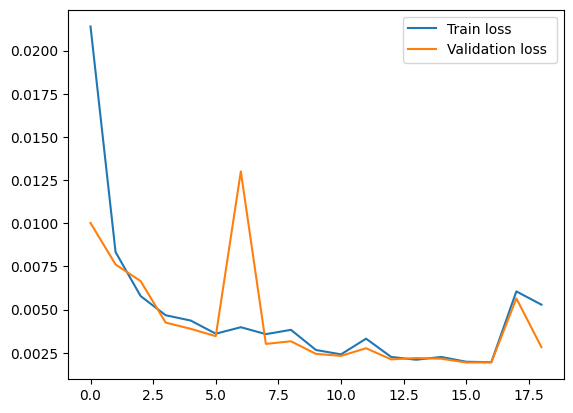

In [9]:
plot_learning_curve(model)

In [10]:
model.autoencoder.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 232)]             0         
                                                                 
 dense (Dense)               (None, 300)               69900     
                                                                 
 dense_1 (Dense)             (None, 120)               36120     
                                                                 
 dense_2 (Dense)             (None, 40)                4840      
                                                                 
 encoded (Dense)             (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 50)                1050      
                                                                 
 dense_4 (Dense)             (None, 80)                4080  

## New threshold selection method

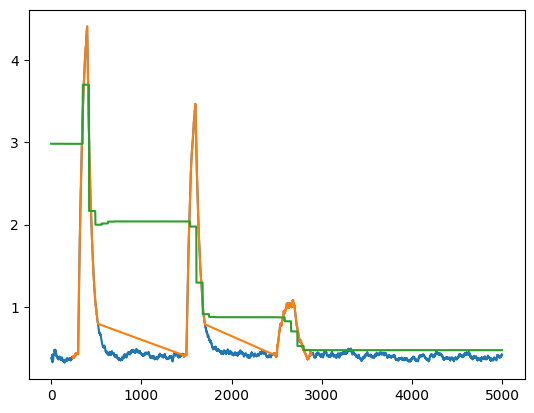

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from example_models.example_threshold import TelemanomThreshold  # our new threshold selection method

# Simulating some synthetic data
np.random.seed(42)
n_points = 5000
data = np.random.normal(loc=0, scale=1, size=n_points)  # Normal data

# Simulating predicted values (for example, from a model)
predicted_values = data + np.random.normal(0, 0.5, n_points)  # Adding noise to predictions

data[300:400] += 5  # Simulate an anomaly
data[1500:1600] += 4  # Another anomaly
data[2500:2700] += 1  # Another anomaly

prediction_error = np.array([abs(y_h-y_t) for y_h, y_t in zip(predicted_values, data)])

ts = TelemanomThreshold()
# ts.fit(prediction_error)
predicted_anomalies = ts.predict(prediction_error)

plt.plot(ts.smoothed_errors, label='smoothed error')
pd.Series(ts.smoothed_errors)[predicted_anomalies].plot(label='anomalies')
plt.plot(ts.threshold, label='threshold')

In [12]:
# register the new threshold method
# register the new autoencoder class, so we can use it in the FaultDetector class
register(
    module_path='example_models.example_threshold.TelemanomThreshold',
    class_type='threshold_selector',
    class_names=['TelemanomThreshold', 'telemanom']
)

In [13]:
registry.print_available_classes()


Available classes for autoencoder:
Class: energy_fault_detection.autoencoders.MultilayerAutoencoder 
Config names: ['MultilayerAutoencoder', 'KerasAutoencoder', 'keras_autoencoder', 'default', 'dense']
Class: example_models.example_autoencoder.NewAE 
Config names: ['new_ae']

Available classes for anomaly_score:
Class: energy_fault_detection.anomaly_scores.MahalanobisScore 
Config names: ['MahalanobisScore', 'Mahalanobis', 'mahalanobis']
Class: energy_fault_detection.anomaly_scores.RMSEScore 
Config names: ['RMSEScore', 'RMSE', 'rmse']

Available classes for threshold_selector:
Class: energy_fault_detection.threshold_selectors.FDRSelector 
Config names: ['FDRSelector', 'FDR_selector', 'fdr_selector', 'FDR', 'fdr']
Class: energy_fault_detection.threshold_selectors.FbetaSelector 
Config names: ['FbetaSelector', 'Fbeta_selector', 'fbeta_selector', 'fbeta']
Class: energy_fault_detection.threshold_selectors.QuantileThresholdSelector 
Config names: ['QuantileThresholdSelector', 'quantile_se

In [14]:
# configure an FaultDetector with the new model classes

# create a new configuration file
conf = {
    'data_clipping': {
        'lower_percentile': 0.001,
        'upper_percentile': 0.999
    },
    'data_preprocessor': {
        'params': {
            'include_column_selector': True,
            'include_low_unique_value_filter': True,
            'include_duplicate_value_to_nan': False,
            'max_col_zero_frac': 0.99,
            'max_nan_frac_per_col': 0.05,
            'min_unique_value_count': 10,
            'scale': 'minmax'
        }
    },
    'data_splitter': {
        'shuffle': True,
        'type': 'sklearn',
        'validation_split': 0.25
    },
    'autoencoder': {
        'name': 'new_ae',  # use the new autoencoder
        'verbose': 0,
        'params': {
            'batch_size': 128,
            'early_stopping': True,
            'epochs': 100,
            'encoder_layers': [300, 120, 40],
            'decoder_layers': [50, 80, 200],
            'code_size': 20,
            'learning_rate': 0.005,
        }
    },
    'anomaly_score': {'name': 'rmse'},
    'threshold_selector': {
        'name': 'telemanom',  # use new threshold
        'fit_on_val': False,
        'params': {
            'batch_size': 72,
            'window_size': 50
        }
    }
}

config = Config(config_dict={'train': conf})

In [15]:
model = FaultDetector(config)
model.threshold_selector

2025-07-03 13:08:45,848 - fault_detection - INFO - Initialize models..


,window_size,50
,batch_size,72
,smoothing_perc,0.05
,l_s,10
,error_buffer,100
,p,0.13


In [16]:
train_results = model.fit(x_train, y_train, save_models=False)

2025-07-03 13:08:45,978 - fault_detection - INFO - Clip data before scaling.
2025-07-03 13:08:46,595 - fault_detection - INFO - Fit preprocessor pipeline.
2025-07-03 13:08:47,863 - fault_detection - INFO - Train autoencoder.
1643/1643 [==============================] - 2s 1ms/step
2025-07-03 13:09:18,732 - fault_detection - INFO - Fit threshold.


327/327 [==============================] - 0s 922us/step


(<Figure size 800x300 with 1 Axes>, <Axes: ylabel='anomaly score'>)

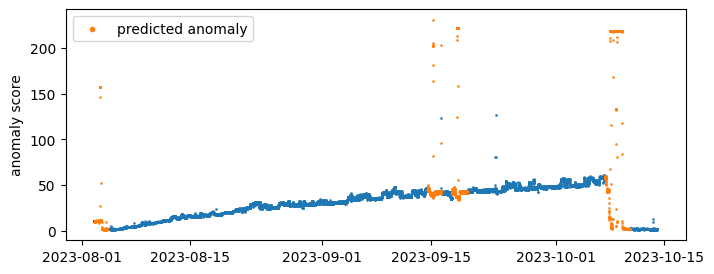

In [17]:
# The type of threshold does not work well if almost the whole window is an anomaly

from energy_fault_detector.utils.visualisation import plot_score_with_threshold

plot_score_with_threshold(
    model,
    x_test,
    show_predicted_anomaly=True,
    show_threshold=False
)

1826/1826 [==============================] - 2s 1ms/step


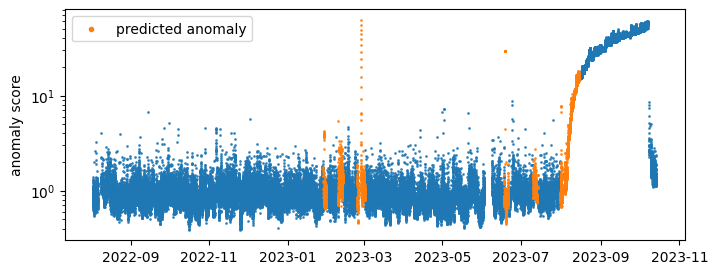

In [18]:
fig, ax = plot_score_with_threshold(
    model,
    pd.concat([x_train, x_test])[pd.concat([y_train, y_test])],  # try to find a threshold for the whole dataset without the anomalous statuses
    show_predicted_anomaly=True,
    show_threshold=False
)

ax.set_yscale('log')